# Sample Pipeline:
  - Load small training set (20 maps) from:

        train/images/*.png

        train/labels/*.json     # contains true class grid

        train/velocities/*.json # boost; we ignore it in this baseline

  - Train a tiny NN that predicts a 20x20 class grid from the image.

        * It treats all terrains together (no terrain-specific modeling).

        * It only uses per-cell average colour (super crude).

  - For each test image:

        * Predict class grid.

        * Find start (class 3) and goal (class 4).

        * Compute a path with a dumb cost model (ignoring boosts).

        * Convert path to an 'lrud' sequence and write submission_baseline.csv
        

In [1]:
# Imports
import json
import math
import heapq
from collections import deque
from pathlib import Path
from typing import List, Tuple, Dict, Optional
import random
import copy

import numpy as np
from PIL import Image, ImageEnhance, ImageFilter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau, OneCycleLR

# Optional: For mixed precision training (faster on GPU)
from torch.cuda.amp import autocast, GradScaler

# For pretrained models
import torchvision.models as models
import torchvision.transforms as T

In [ ]:
# ==================== CONFIGURATION ====================
GRID_SIZE = 20
NUM_CLASSES = 5  # 0..4

# ----- DATASET SIZE SETTINGS -----
# Set this based on how many training samples you have:
#   - Small (20 samples): USE_LARGE_DATASET = False
#   - Large (200+ samples): USE_LARGE_DATASET = True
USE_LARGE_DATASET = True  # <-- CHANGE THIS after generating synthetic data!

if USE_LARGE_DATASET:
    # Settings for larger dataset (200+ samples)
    BATCH_SIZE = 64
    EPOCHS = 60
    LR = 1e-3  # Higher LR for OneCycleLR
    WEIGHT_DECAY = 1e-4
    PATIENCE = 10
    VAL_SPLIT = 0.20  # Use 20% for validation
    USE_PRETRAINED = True   # Use pretrained backbone
    USE_AUGMENTATION = True  # Enable data augmentation
    USE_MIXUP = True         # Enable mixup augmentation
    USE_TTA = True           # Enable test-time augmentation
    print("CONFIG: Large dataset mode (3000+ samples)")
else:
    # Settings for small dataset (20 samples)
    BATCH_SIZE = 4
    EPOCHS = 100
    LR = 5e-4
    WEIGHT_DECAY = 1e-5
    PATIENCE = 15
    VAL_SPLIT = 0.0   # No validation split
    USE_PRETRAINED = False
    USE_AUGMENTATION = False
    USE_MIXUP = False
    USE_TTA = False
    print("CONFIG: Small dataset mode (20 samples)")

MIN_LR = 1e-6

# Image size for CNN input (larger for pretrained models)
IMG_SIZE = 224 if USE_PRETRAINED else 128

# Focal Loss parameters
FOCAL_GAMMA = 2.0  # Focus on hard examples
FOCAL_ALPHA = None  # Use class weights instead

# Mixup parameters
MIXUP_ALPHA = 0.4

# TTA settings
TTA_AUGMENTS = 4  # Number of augmented versions for TTA

BASE_DIR = Path.cwd()

TRAIN_IMAGES_DIR = BASE_DIR / "train" / "images"
TRAIN_LABELS_DIR = BASE_DIR / "train" / "labels"
TRAIN_VELOCITIES_DIR = BASE_DIR / "train" / "velocities"

TEST_IMAGES_DIR = BASE_DIR / "test" / "images"
TEST_VELOCITIES_DIR = BASE_DIR / "test" / "velocities"

SUBMISSION_PATH = BASE_DIR / "submission.csv"

# Device setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Class weights (higher = more important to get right)
# Increased weights for rare classes
CLASS_WEIGHTS = torch.tensor(
    [0.3,    # 0 = walkable (most common, lower weight)
     2.0,    # 1 = wall
     1.5,    # 2 = hazard
     15.0,   # 3 = start (rare but critical!)
     15.0],  # 4 = goal (rare but critical!)
    dtype=torch.float32
)

CLASS_WALKABLE = 0
CLASS_WALL = 1
CLASS_HAZARD = 2
CLASS_START = 3
CLASS_GOAL = 4
CLASS_WALL2 = 1
# Seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True  # Faster training

CONFIG: Large dataset mode (3000+ samples)
Using device: cuda


In [21]:
# ==================== SYNTHETIC DATA GENERATOR (USING REAL TEXTURES) ====================
# This generator uses the actual tile assets to create realistic training data!

import os
from PIL import Image, ImageDraw

# Asset paths for each terrain type
TERRAIN_ASSETS = {
    "forest": {
        "walkable": "t0_dirt.png",
        "wall": ["t0_tree.png","t0_tree.png"],
                                              
        "hazard": "t0_puddle.png",
        "start": "t0_startship.png",
        "goal": "t0_goal.png",
    },
    "desert": {
        "walkable": "t1_sand.png",
        "wall": ["t1_rocks.png","t1_cacti.png"],
        # "wall2": "t0_tree.png",
        "hazard": "t1_quicksand.png",
        "start": "t1_rover.png",
        "goal": "t1_goal.png",
    },
    "lab": {
        "walkable": "t2_floor.png",
        "wall": ["t2_wall.png","t2_plasma.png"],
        # "wall2": "t0_tree.png",
        "hazard": "t2_glue.png",  # or t2_plasma.png
        "start": "t2_drone.png",
        "goal": "t2_goal.png",
    },
}

# Map class IDs to asset keys
CLASS_TO_ASSET_KEY = {
    CLASS_WALKABLE: "walkable",                            
    CLASS_WALL: "wall",
    # CLASS_WALL2: "wall2",
    CLASS_HAZARD: "hazard",
    CLASS_START: "start",
    CLASS_GOAL: "goal",
}


def load_terrain_tiles(terrain: str, tile_size: int = 20) :
    """Load and resize texture tiles for a terrain type."""
    assets_dir = BASE_DIR / "assets" / terrain
    asset_mapping = TERRAIN_ASSETS[terrain]
    
    tiles = {}
    for class_id, asset_key in CLASS_TO_ASSET_KEY.items():
        asset_file = asset_mapping[asset_key]
        if asset_key == "wall":
            asset_path = [assets_dir / f for f in asset_file]
        else:
            asset_path = assets_dir / asset_file
        tiles[class_id]=asset_path
        # tile = Image.open(asset_path).convert("RGB")
        # tile = tile.resize((tile_size, tile_size), Image.BILINEAR)
        # tiles[class_id] = tile
        
    return tiles


def generate_random_grid(grid_size: int = 20, wall_prob: float = 0.15, hazard_prob: float = 0.1) -> np.ndarray:
    """
    Generate a random grid with:
      - Walls (~15% of cells)
      - Hazards (~10% of cells)
      - Exactly 1 start and 1 goal
      - Rest are walkable
    """
    grid = np.zeros((grid_size, grid_size), dtype=np.int64)
    

    # Fill with walls and hazards randomly
    for i in range(grid_size):
        for j in range(grid_size):
            grid[i, j] = CLASS_WALKABLE
    #         r = random.random()
    #         if r < wall_prob:
    #             grid[i, j] = CLASS_WALL
    #         elif r < wall_prob + hazard_prob:  #!!!! doubt here             ......................................
    #             grid[i, j] = CLASS_HAZARD
    #         else:
    #             
    nsp = random.uniform(0.30,0.50) # percentage of special cells in the map between 30 to 50 percent
    all_coordinates = [(x,y) for x in range(grid_size) for y in range(grid_size) ]
    chosen_coordinates = random.sample(all_coordinates, int(nsp * grid_size * grid_size))
    nw = random.uniform(0.2,0.4) # percentage of wall cells among special cells between 20 to 40 percent
    random.shuffle(chosen_coordinates)
    nw = int(len(chosen_coordinates) * nw)
    for n in range(len(chosen_coordinates)):
        if n+1 <= nw:
            grid[chosen_coordinates[n][0], chosen_coordinates[n][1]] = CLASS_WALL
        else:
            grid[chosen_coordinates[n][0], chosen_coordinates[n][1]] = CLASS_HAZARD
            



    # Get walkable cells
    walkable_cells = [(i, j) for i in range(grid_size) for j in range(grid_size) if grid[i, j] == CLASS_WALKABLE]
    
    # if len(walkable_cells) < 2:
    #     # Not enough walkable cells, clear some walls
    #     for i in range(grid_size):
    #         for j in range(grid_size):
    #             if grid[i, j] == CLASS_WALL and random.random() < 0.5:
    #                 grid[i, j] = CLASS_WALKABLE
    #     walkable_cells = [(i, j) for i in range(grid_size) for j in range(grid_size) if grid[i, j] == CLASS_WALKABLE]
    
    # Pick start and goal (try to place far apart)
    random.shuffle(walkable_cells)
    start = walkable_cells[0]
    
    best_goal = walkable_cells[1]
    best_dist = 0
    for cell in walkable_cells[1:min(20, len(walkable_cells))]:
        dist = abs(cell[0] - start[0]) + abs(cell[1] - start[1])
        if dist > best_dist:
            best_dist = dist
            best_goal = cell
    
    grid[start[0], start[1]] = CLASS_START
    grid[best_goal[0], best_goal[1]] = CLASS_GOAL
    
    return grid


def generate_velocity_grid(grid_size: int = 20) -> np.ndarray:
    """Generate random velocity/boost values between -0.5 and 0.5."""
    return np.random.uniform(-0.99, 0.99, (grid_size, grid_size)).astype(np.float32)     
# Try changing the np.random.uniform function to something more efficient , because this may cause the map to generate random images.


def grid_to_image_with_textures(
    grid: np.ndarray,
    tiles,  
    img_size: int = 400,
) -> Image.Image:
    """
    Convert a class grid to an image using actual texture tiles.
    This creates images that look like the real training data!
    """
    grid_size = grid.shape[0]
    tile_size = img_size // grid_size
    
    # Resize tiles if needed
    resized_tiles = {}
    for class_id, tile in tiles.items():
        if type(tile) == list:
            resized_tiles[class_id] = [Image.open(t).convert("RGB").resize((tile_size, tile_size), Image.BILINEAR) for t in tile]
        else:
            resized_tiles[class_id] = Image.open(tile).convert("RGB").resize((tile_size, tile_size), Image.BILINEAR)
    
    img = Image.new("RGB", (img_size, img_size))
    
    for i in range(grid_size):
        for j in range(grid_size):
            cell_class = grid[i, j]
            tile = resized_tiles.get(cell_class)
            
            x = j * tile_size
            y = i * tile_size
            if cell_class == CLASS_WALL:
                tile1 = random.choice(tile)
                img.paste(tile1, (x, y))
            else:
                img.paste(tile, (x, y))

            # img.paste(tile if cell_class != CLASS_WALL else np.random.choice(tile), (x, y))
    
    return img


def generate_synthetic_dataset(
    num_samples: int = 100,
    output_dir: Path = None,
    start_id: int = 21,
    grid_size: int = 20,
    img_size: int = 400,
    terrains: List[str] = None,  # Which terrains to use
):
    """
    Generate synthetic training data using REAL texture assets.
    
    Args:
        num_samples: Number of samples to generate
        output_dir: Base directory (default: current folder)
        start_id: Starting ID number
        grid_size: Size of the grid (20x20)
        img_size: Size of output images in pixels
        terrains: List of terrains to use ["forest", "desert", "lab"]
    """
    if output_dir is None:
        output_dir = BASE_DIR
    
    if terrains is None:
        terrains = ["forest", "desert", "lab"]
    
    images_dir = output_dir / "train" / "images"
    labels_dir = output_dir / "train" / "labels"
    velocities_dir = output_dir / "train" / "velocities"
    
    images_dir.mkdir(parents=True, exist_ok=True)
    labels_dir.mkdir(parents=True, exist_ok=True)
    velocities_dir.mkdir(parents=True, exist_ok=True)
    
    # Load texture tiles for each terrain
    print(f"Loading texture assets from: {BASE_DIR / 'assets'}")
    terrain_tiles = {}
    for terrain in terrains:
        terrain_tiles[terrain] = load_terrain_tiles(terrain, tile_size=img_size // grid_size)
        print(f"  Loaded {terrain} textures")
    
    print(f"\nGenerating {num_samples} synthetic samples...")
    print(f"  Using terrains: {terrains}")
    print(f"  Output: {images_dir}")
    
    for i in range(num_samples):
        sample_id = f"{start_id + i:04d}"
        
        # Randomly pick a terrain for this sample
        terrain = random.choice(terrains)
        tiles = terrain_tiles[terrain]
        
        # Generate random grid
        grid = generate_random_grid(grid_size)
        
        # Generate velocity grid
        velocity = generate_velocity_grid(grid_size)
        
        # Create image using real textures
        img = grid_to_image_with_textures(grid, tiles, img_size)
        
        # Save image
        img_path = images_dir / f"{sample_id}.png"
        img.save(img_path)
        
        # Save label JSON
        label_path = labels_dir / f"{sample_id}.json"
        with open(label_path, "w") as f:
            json.dump({"grid": grid.tolist()}, f)
        
        # Save velocity JSON
        velocity_path = velocities_dir / f"{sample_id}.json"
        with open(velocity_path, "w") as f:
            json.dump({"boost": velocity.tolist()}, f)
        
        if (i + 1) % 20 == 0:
            print(f"  Generated {i + 1}/{num_samples}")
    
    print(f"\n✓ Generated {num_samples} samples (IDs {start_id:04d} to {start_id + num_samples - 1:04d})")
    print("  Samples use actual texture assets for realistic images!")
    print("  Re-run training to use the new data.")


# ===== USAGE =====
# Uncomment and run to generate data:

# generate_synthetic_dataset(
#     num_samples=100,   # How many samples to create
#     start_id=21,       # Start after existing 0001-0020
#     terrains=["forest", "desert", "lab"],  # Use all terrain types
# )

In [ ]:
# ==================== GENERATE SYNTHETIC DATA ====================
# Run this cell ONCE to generate 300 synthetic training samples!
# After generating, the model will have much more data to learn from.

GENERATE_DATA = True  # Set to True and run this cell to generate data

if GENERATE_DATA:
    print("=" * 60)
    print("GENERATING SYNTHETIC TRAINING DATA")
    print("=" * 60)
    
    generate_synthetic_dataset(
        num_samples=3000,        # Genrt 300 samples
        output_dir= BASE_DIR,
        start_id=321,            # Start after existing 0001-0020
        terrains=["forest", "desert", "lab"],  # Use all terrain types
        img_size=400,           # Higher resolution source images
    )
    
    print("\n✓ Data generation complete!")
    print("You now have ~3000+ training samples.")
    print("The model will use augmented versions of these for even more variety.")
else:
    print("Skipping data generation. Set GENERATE_DATA = True to generate.")
    print(f"Current training samples: {len(list(TRAIN_IMAGES_DIR.glob('*.png')))}")

GENERATING SYNTHETIC TRAINING DATA
Loading texture assets from: d:\projects\synapse drive\PS1\project_files\SynapseDrive_Dataset\assets
  Loaded forest textures
  Loaded desert textures
  Loaded lab textures

Generating 3000 synthetic samples...
  Using terrains: ['forest', 'desert', 'lab']
  Output: d:\projects\synapse drive\PS1\project_files\SynapseDrive_Dataset\train\images
  Generated 20/3000
  Generated 40/3000
  Generated 60/3000
  Generated 80/3000
  Generated 100/3000
  Generated 120/3000
  Generated 140/3000
  Generated 160/3000
  Generated 180/3000
  Generated 200/3000
  Generated 220/3000
  Generated 240/3000
  Generated 260/3000
  Generated 280/3000
  Generated 300/3000
  Generated 320/3000
  Generated 340/3000
  Generated 360/3000
  Generated 380/3000
  Generated 400/3000
  Generated 420/3000
  Generated 440/3000
  Generated 460/3000
  Generated 480/3000
  Generated 500/3000
  Generated 520/3000
  Generated 540/3000
  Generated 560/3000
  Generated 580/3000
  Generated 600

In [22]:
# ==================== DATA LOADING WITH AUGMENTATION ====================

def load_label_grid(json_path: Path) -> np.ndarray:
    """Load true class grid from label JSON (expects key 'grid')."""
    with json_path.open("r", encoding="utf-8") as f:
        data = json.load(f)
    if "grid" not in data:
        raise KeyError(f"'grid' not found in {json_path}.")
    grid = np.array(data["grid"], dtype=np.int64)
    assert grid.shape == (GRID_SIZE, GRID_SIZE), f"Expected {GRID_SIZE}x{GRID_SIZE}, got {grid.shape}"
    return grid


def load_velocity_grid(json_path: Path) -> Optional[np.ndarray]:
    """Load velocity/boost grid from JSON file."""
    try:
        with json_path.open("r", encoding="utf-8") as f:
            data = json.load(f)
        if "boost" in data:
            return np.array(data["boost"], dtype=np.float32)
    except:
        pass
    return None


# ==================== AUGMENTATION FUNCTIONS ====================

def augment_image_and_grid(img_arr: np.ndarray, grid: np.ndarray, aug_type: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Apply geometric augmentation to both image and grid.
    Supports flips and 90° rotations that preserve grid structure.
    
    aug_type:
        0 = no augmentation
        1 = horizontal flip
        2 = vertical flip
        3 = rotate 90° CW
        4 = rotate 180°
        5 = rotate 270° CW (90° CCW)
        6 = horizontal flip + rotate 90°
        7 = vertical flip + rotate 90°
    """
    img = img_arr.copy()
    g = grid.copy()
    
    if aug_type == 0:
        pass
    elif aug_type == 1:  # Horizontal flip
        img = np.flip(img, axis=1).copy()
        g = np.flip(g, axis=1).copy()
    elif aug_type == 2:  # Vertical flip
        img = np.flip(img, axis=0).copy()
        g = np.flip(g, axis=0).copy()
    elif aug_type == 3:  # Rotate 90° CW
        img = np.rot90(img, k=-1, axes=(0, 1)).copy()
        g = np.rot90(g, k=-1).copy()
    elif aug_type == 4:  # Rotate 180°
        img = np.rot90(img, k=2, axes=(0, 1)).copy()
        g = np.rot90(g, k=2).copy()
    elif aug_type == 5:  # Rotate 270° CW
        img = np.rot90(img, k=1, axes=(0, 1)).copy()
        g = np.rot90(g, k=1).copy()
    elif aug_type == 6:  # H-flip + rotate 90°
        img = np.flip(img, axis=1).copy()
        g = np.flip(g, axis=1).copy()
        img = np.rot90(img, k=-1, axes=(0, 1)).copy()
        g = np.rot90(g, k=-1).copy()
    elif aug_type == 7:  # V-flip + rotate 90°
        img = np.flip(img, axis=0).copy()
        g = np.flip(g, axis=0).copy()
        img = np.rot90(img, k=-1, axes=(0, 1)).copy()
        g = np.rot90(g, k=-1).copy()
    
    return img, g


def color_jitter(img_arr: np.ndarray, strength: float = 0.2) -> np.ndarray:
    """Apply random color jittering to image array."""
    img = img_arr.copy()
    
    # Random brightness
    brightness = 1.0 + random.uniform(-strength, strength)
    img = np.clip(img * brightness, 0, 1)
    
    # Random contrast
    contrast = 1.0 + random.uniform(-strength, strength)
    mean = img.mean()
    img = np.clip((img - mean) * contrast + mean, 0, 1)
    
    # Random saturation (simple approximation)
    if random.random() < 0.5:
        gray = img.mean(axis=2, keepdims=True)
        saturation = 1.0 + random.uniform(-strength, strength)
        img = np.clip(gray + (img - gray) * saturation, 0, 1)
    
    return img.astype(np.float32)


class AugmentedGridDataset(Dataset):
    """
    Dataset with geometric and color augmentation.
    Augmentations preserve the correspondence between image and grid.
    """

    def __init__(
        self,
        images_dir: Path,
        labels_dir: Path,
        grid_size: int,
        augment: bool = True,
        color_aug: bool = True,
    ):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.grid_size = grid_size
        self.augment = augment
        self.color_aug = color_aug
        self._cache: Dict[str, Tuple[np.ndarray, np.ndarray]] = {}

        self.image_ids: List[str] = []
        for p in sorted(labels_dir.glob("*.json")):
            image_id = p.stem
            img_path = images_dir / f"{image_id}.png"
            if img_path.is_file():
                self.image_ids.append(image_id)

        if not self.image_ids:
            raise RuntimeError(f"No training labels/images found in {labels_dir}")
        
        print(f"Dataset: {len(self.image_ids)} samples (augment={augment})")

    def __len__(self) -> int:
        return len(self.image_ids)

    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx]
        
        # Check cache
        if image_id in self._cache:
            img_arr, grid = self._cache[image_id]
            img_arr = img_arr.copy()
            grid = grid.copy()
        else:
            img_path = self.images_dir / f"{image_id}.png"
            label_path = self.labels_dir / f"{image_id}.json"
            
            img = Image.open(img_path).convert("RGB")
            img = img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
            img_arr = np.array(img, dtype=np.float32) / 255.0  # (H, W, 3)
            
            grid = load_label_grid(label_path)  # (G, G)
            self._cache[image_id] = (img_arr.copy(), grid.copy())
        
        # Apply geometric augmentation
        if self.augment:
            aug_type = random.randint(0, 7)
            img_arr, grid = augment_image_and_grid(img_arr, grid, aug_type)
            
            # Color augmentation (image only)
            if self.color_aug and random.random() < 0.5:
                img_arr = color_jitter(img_arr, strength=0.15)
        
        # Convert to tensors
        img_arr = np.transpose(img_arr, (2, 0, 1))  # (3, H, W)
        x = torch.from_numpy(img_arr.copy()).float()
        y = torch.from_numpy(grid.copy()).long()
        
        return x, y


# Original simple dataset for compatibility
class GridDataset(Dataset):
    """Simple dataset - NO augmentation."""

    def __init__(
        self,
        images_dir: Path,
        labels_dir: Path,
        grid_size: int,
    ):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.grid_size = grid_size
        self._cache: Dict[str, Tuple[np.ndarray, np.ndarray]] = {}

        self.image_ids: List[str] = []
        for p in sorted(labels_dir.glob("*.json")):
            image_id = p.stem
            img_path = images_dir / f"{image_id}.png"
            if img_path.is_file():
                self.image_ids.append(image_id)

        if not self.image_ids:
            raise RuntimeError(f"No training labels/images found in {labels_dir}")
        
        print(f"Dataset: {len(self.image_ids)} samples")

    def __len__(self) -> int:
        return len(self.image_ids)

    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx]
        
        if image_id in self._cache:
            img_arr, grid = self._cache[image_id]
        else:
            img_path = self.images_dir / f"{image_id}.png"
            label_path = self.labels_dir / f"{image_id}.json"
            
            img = Image.open(img_path).convert("RGB")
            img = img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
            img_arr = np.array(img, dtype=np.float32) / 255.0
            
            grid = load_label_grid(label_path)
            self._cache[image_id] = (img_arr, grid)
        
        img_arr = np.transpose(img_arr, (2, 0, 1))
        x = torch.from_numpy(img_arr.copy()).float()
        y = torch.from_numpy(grid.copy()).long()
        
        return x, y

In [23]:
# ==================== IMPROVED MODEL ARCHITECTURES ====================

# ==================== FOCAL LOSS ====================
class FocalLoss(nn.Module):
    """
    Focal Loss for handling class imbalance.
    Focuses on hard-to-classify examples by down-weighting easy ones.
    
    FL(p_t) = -alpha * (1 - p_t)^gamma * log(p_t)
    """
    def __init__(self, gamma: float = 2.0, alpha: Optional[torch.Tensor] = None, reduction: str = 'mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
    
    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Args:
            inputs: (B, C, H, W) or (B, C, N) logits
            targets: (B, H, W) or (B, N) class indices
        """
        ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        
        # Get probabilities
        p = F.softmax(inputs, dim=1)
        
        # Gather the probabilities of the target classes
        B = targets.shape[0]
        if inputs.dim() == 4:  # (B, C, H, W)
            targets_flat = targets.view(B, -1)  # (B, H*W)
            p_flat = p.view(B, p.shape[1], -1)  # (B, C, H*W)
            p_t = p_flat.gather(1, targets_flat.unsqueeze(1)).squeeze(1)  # (B, H*W)
        else:  # (B, C, N)
            p_t = p.gather(1, targets.unsqueeze(1)).squeeze(1)  # (B, N)
        
        # Focal weight
        focal_weight = (1 - p_t) ** self.gamma
        
        # Reshape ce_loss to match focal_weight
        if ce_loss.dim() > 2:
            ce_loss = ce_loss.view(B, -1)
        
        focal_loss = focal_weight * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss


# ==================== MIXUP AUGMENTATION ====================
def mixup_data(x: torch.Tensor, y: torch.Tensor, alpha: float = 0.4):
    """
    Apply mixup augmentation.
    Returns mixed inputs, pairs of targets, and lambda.
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Compute loss for mixup."""
    B, C, G, _ = pred.shape
    pred_flat = pred.view(B, C, -1)
    y_a_flat = y_a.view(B, -1)
    y_b_flat = y_b.view(B, -1)
    
    return lam * criterion(pred_flat, y_a_flat) + (1 - lam) * criterion(pred_flat, y_b_flat)


# ==================== PRETRAINED RESNET BACKBONE ====================
class ResNetUNet(nn.Module):
    """
    U-Net with pretrained ResNet34 encoder.
    Leverages ImageNet features for better generalization.
    """
    
    def __init__(self, grid_size: int, num_classes: int, pretrained: bool = True):
        super().__init__()
        self.grid_size = grid_size
        self.num_classes = num_classes
        
        # Load pretrained ResNet34
        resnet = models.resnet34(weights='IMAGENET1K_V1' if pretrained else None)
        
        # Encoder layers from ResNet
        self.encoder0 = nn.Sequential(
            resnet.conv1,   # 3 -> 64, stride=2
            resnet.bn1,
            resnet.relu,
        )  # Output: 64 channels, /2
        
        self.pool0 = resnet.maxpool  # /4
        self.encoder1 = resnet.layer1  # 64 -> 64, /4
        self.encoder2 = resnet.layer2  # 64 -> 128, /8
        self.encoder3 = resnet.layer3  # 128 -> 256, /16
        self.encoder4 = resnet.layer4  # 256 -> 512, /32
        
        # Decoder with skip connections
        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec4 = self._make_decoder_block(512, 256)  # 256+256
        
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = self._make_decoder_block(256, 128)  # 128+128
        
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = self._make_decoder_block(128, 64)  # 64+64
        
        self.up1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec1 = self._make_decoder_block(128, 64)  # 64+64
        
        self.up0 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec0 = self._make_decoder_block(32, 32)
        
        # Adaptive pool to grid size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((grid_size, grid_size))
        
        # Final classifier
        self.classifier = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            nn.Conv2d(64, num_classes, kernel_size=1),
        )
    
    def _make_decoder_block(self, in_ch: int, out_ch: int):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Encoder
        e0 = self.encoder0(x)      # (B, 64, H/2, W/2)
        e0_pool = self.pool0(e0)   # (B, 64, H/4, W/4)
        e1 = self.encoder1(e0_pool)  # (B, 64, H/4, W/4)
        e2 = self.encoder2(e1)     # (B, 128, H/8, W/8)
        e3 = self.encoder3(e2)     # (B, 256, H/16, W/16)
        e4 = self.encoder4(e3)     # (B, 512, H/32, W/32)
        
        # Decoder with skip connections
        d4 = self.up4(e4)          # (B, 256, H/16, W/16)
        d4 = torch.cat([d4, e3], dim=1)  # (B, 512, H/16, W/16)
        d4 = self.dec4(d4)         # (B, 256, H/16, W/16)
        
        d3 = self.up3(d4)          # (B, 128, H/8, W/8)
        d3 = torch.cat([d3, e2], dim=1)  # (B, 256, H/8, W/8)
        d3 = self.dec3(d3)         # (B, 128, H/8, W/8)
        
        d2 = self.up2(d3)          # (B, 64, H/4, W/4)
        d2 = torch.cat([d2, e1], dim=1)  # (B, 128, H/4, W/4)
        d2 = self.dec2(d2)         # (B, 64, H/4, W/4)
        
        d1 = self.up1(d2)          # (B, 64, H/2, W/2)
        d1 = torch.cat([d1, e0], dim=1)  # (B, 128, H/2, W/2)
        d1 = self.dec1(d1)         # (B, 64, H/2, W/2)
        
        d0 = self.up0(d1)          # (B, 32, H, W)
        d0 = self.dec0(d0)         # (B, 32, H, W)
        
        # Pool to grid size and classify
        out = self.adaptive_pool(d0)  # (B, 32, G, G)
        out = self.classifier(out)    # (B, num_classes, G, G)
        
        return out


class ConvBlock(nn.Module):
    """Convolution block with BatchNorm and activation."""
    def __init__(self, in_ch, out_ch, kernel_size=3, padding=1, dropout=0.0):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_ch)
        self.dropout = nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()
        
    def forward(self, x):
        return self.dropout(F.relu(self.bn(self.conv(x))))


class UNetLikeGridNet(nn.Module):
    """
    U-Net inspired architecture with skip connections for better spatial preservation.
    """
    
    def __init__(self, grid_size: int, num_classes: int, dropout: float = 0.2):
        super().__init__()
        self.grid_size = grid_size
        self.num_classes = num_classes
        
        # Encoder (downsampling path)
        self.enc1 = nn.Sequential(
            ConvBlock(3, 32, dropout=dropout),
            ConvBlock(32, 32, dropout=dropout),
        )
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = nn.Sequential(
            ConvBlock(32, 64, dropout=dropout),
            ConvBlock(64, 64, dropout=dropout),
        )
        self.pool2 = nn.MaxPool2d(2)
        
        self.enc3 = nn.Sequential(
            ConvBlock(64, 128, dropout=dropout),
            ConvBlock(128, 128, dropout=dropout),
        )
        self.pool3 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            ConvBlock(128, 256, dropout=dropout),
            ConvBlock(256, 256, dropout=dropout),
        )
        
        # Decoder with skip connections
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(
            ConvBlock(256, 128, dropout=dropout),
            ConvBlock(128, 128, dropout=dropout),
        )
        
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            ConvBlock(128, 64, dropout=dropout),
            ConvBlock(64, 64, dropout=dropout),
        )
        
        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            ConvBlock(64, 32, dropout=dropout),
            ConvBlock(32, 32, dropout=dropout),
        )
        
        # Adaptive pooling to grid size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((grid_size, grid_size))
        
        # Final classifier
        self.classifier = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=1),
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        
        b = self.bottleneck(self.pool3(e3))
        
        d3 = self.up3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        out = self.adaptive_pool(d1)
        out = self.classifier(out)
        
        return out


class SimpleGridNet(nn.Module):
    """Original simple CNN (kept for comparison)."""
    
    def __init__(self, grid_size: int, num_classes: int):
        super().__init__()
        self.grid_size = grid_size
        self.num_classes = num_classes

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d((grid_size, grid_size))
        
        self.classifier = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, num_classes, kernel_size=1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.adaptive_pool(x)
        x = self.classifier(x)
        return x

In [24]:
# ==================== IMPROVED TRAINING LOOP ====================

def compute_accuracy(logits: torch.Tensor, targets: torch.Tensor) -> float:
    """Compute pixel-wise accuracy."""
    preds = torch.argmax(logits, dim=1)
    correct = (preds == targets).float().sum()
    total = targets.numel()
    return (correct / total).item()


def compute_class_accuracy(logits: torch.Tensor, targets: torch.Tensor, num_classes: int = NUM_CLASSES) -> Dict[int, float]:
    """Compute per-class accuracy (useful for tracking rare classes)."""
    preds = torch.argmax(logits, dim=1)
    accuracies = {}
    
    for c in range(num_classes):
        mask = targets == c
        if mask.sum() > 0:
            correct = ((preds == c) & mask).float().sum()
            accuracies[c] = (correct / mask.sum()).item()
        else:
            accuracies[c] = 0.0
    
    return accuracies


def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: Optional[DataLoader] = None,
    epochs: int = EPOCHS,
    use_amp: bool = True,
    use_mixup: bool = USE_MIXUP,
    use_focal: bool = True,
) -> Dict[str, List[float]]:
    """
    Advanced training loop with:
      - Focal Loss for class imbalance
      - OneCycleLR for optimal learning rate
      - Mixup augmentation
      - Mixed precision training (AMP)
      - Gradient clipping
      - Early stopping on validation loss
    """
    model.to(DEVICE)
    
    class_weights = CLASS_WEIGHTS.to(DEVICE)
    
    # Use Focal Loss for better handling of rare classes
    if use_focal:
        criterion = FocalLoss(gamma=FOCAL_GAMMA, alpha=class_weights, reduction='mean')
        print("Using Focal Loss (gamma={})".format(FOCAL_GAMMA))
    else:
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        print("Using CrossEntropyLoss")
    
    # AdamW optimizer (better than Adam for weight decay)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    
    # OneCycleLR - aggressive learning rate schedule for faster convergence
    steps_per_epoch = len(train_loader)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=LR,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        pct_start=0.1,  # Warmup for 10% of training
        anneal_strategy='cos',
        div_factor=25.0,  # Initial LR = max_lr / 25
        final_div_factor=1000.0,  # Final LR = max_lr / 1000
    )
    
    # Mixed precision scaler
    scaler = GradScaler() if use_amp and torch.cuda.is_available() else None
    
    # History
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'lr': [],
        'start_acc': [], 'goal_acc': [],  # Track rare class accuracy
    }
    
    # Early stopping
    best_metric = float('inf')
    best_model_state = None
    patience_counter = 0
    
    print(f"Training for up to {epochs} epochs...")
    print(f"Device: {DEVICE}")
    print(f"Mixup: {use_mixup}, AMP: {use_amp and torch.cuda.is_available()}")
    print("-" * 60)
    
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        start_acc_sum = 0.0
        goal_acc_sum = 0.0
        n_batches = 0
        
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            
            # Apply mixup
            if use_mixup and random.random() < 0.5:
                xb, ya, yb_mix, lam = mixup_data(xb, yb, alpha=MIXUP_ALPHA)
                use_mixup_this_batch = True
            else:
                use_mixup_this_batch = False
            
            optimizer.zero_grad()
            
            # Forward pass with optional AMP
            if scaler is not None:
                with autocast():
                    logits = model(xb)
                    if use_mixup_this_batch:
                        loss = mixup_criterion(criterion, logits, ya, yb_mix, lam)
                    else:
                        B, C, G, _ = logits.shape
                        loss = criterion(logits.view(B, C, -1), yb.view(B, -1))
                
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                logits = model(xb)
                if use_mixup_this_batch:
                    loss = mixup_criterion(criterion, logits, ya, yb_mix, lam)
                else:
                    B, C, G, _ = logits.shape
                    loss = criterion(logits.view(B, C, -1), yb.view(B, -1))
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            
            scheduler.step()  # Step per batch for OneCycleLR
            
            train_loss += loss.item() * xb.size(0)
            
            # Compute accuracy (use original yb if mixup)
            if use_mixup_this_batch:
                # For mixup, approximate accuracy
                train_acc += compute_accuracy(logits, ya) * xb.size(0)
            else:
                train_acc += compute_accuracy(logits, yb) * xb.size(0)
                
                # Track rare class accuracy
                class_acc = compute_class_accuracy(logits, yb)
                start_acc_sum += class_acc.get(CLASS_START, 0)
                goal_acc_sum += class_acc.get(CLASS_GOAL, 0)
                n_batches += 1
        
        train_loss /= len(train_loader.dataset)
        train_acc /= len(train_loader.dataset)
        avg_start_acc = start_acc_sum / max(1, n_batches)
        avg_goal_acc = goal_acc_sum / max(1, n_batches)
        
        # Validation
        val_loss, val_acc = 0.0, 0.0
        if val_loader:
            model.eval()
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                    logits = model(xb)
                    B, C, G, _ = logits.shape
                    loss = criterion(logits.view(B, C, -1), yb.view(B, -1))
                    val_loss += loss.item() * xb.size(0)
                    val_acc += compute_accuracy(logits, yb) * xb.size(0)
            val_loss /= len(val_loader.dataset)
            val_acc /= len(val_loader.dataset)
        
        current_lr = optimizer.param_groups[0]['lr']
        
        # Log
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        history['start_acc'].append(avg_start_acc)
        history['goal_acc'].append(avg_goal_acc)
        
        # Print every 10 epochs
        if epoch % 10 == 0 or epoch == 1:
            val_str = f", Val: {val_acc:.3f}" if val_loader else ""
            print(f"Epoch {epoch:03d} | Loss: {train_loss:.4f}, Acc: {train_acc:.3f}{val_str} | Start: {avg_start_acc:.3f}, Goal: {avg_goal_acc:.3f} | LR: {current_lr:.6f}")
        
        # Early stopping on validation loss (or train loss if no validation)
        metric = val_loss if val_loader else train_loss
        if metric < best_metric:
            best_metric = metric
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"\nEarly stopping at epoch {epoch}")
                break
    
    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)
        model.to(DEVICE)
        print(f"\n✓ Restored best model (metric: {best_metric:.4f})")
    
    return history

In [25]:
# ==================== IMPROVED PATHFINDING ====================

def pick_start_goal_from_logits(logits: torch.Tensor) -> Tuple[Tuple[int, int], Tuple[int, int]]:
    """Pick start and goal from logits, ensuring they are different cells."""
    assert logits.shape[0] == 1
    _, C, G, _ = logits.shape

    logit_start = logits[0, CLASS_START, :, :].flatten()
    logit_goal = logits[0, CLASS_GOAL, :, :].flatten()

    start_idx = torch.argmax(logit_start).item()
    goal_idx = torch.argmax(logit_goal).item()

    # Ensure start != goal
    if start_idx == goal_idx:
        logit_goal_masked = logit_goal.clone()
        logit_goal_masked[start_idx] = float('-inf')
        goal_idx = torch.argmax(logit_goal_masked).item()

    return (start_idx // G, start_idx % G), (goal_idx // G, goal_idx % G)


def heuristic(pos: Tuple[int, int], goal: Tuple[int, int]) -> float:
    """Manhattan distance heuristic for A*."""
    return abs(pos[0] - goal[0]) + abs(pos[1] - goal[1])


def compute_movement_cost(
    grid_pred: np.ndarray,
    velocity_grid: Optional[np.ndarray],
    to_pos: Tuple[int, int],
) -> float:
    """
    Compute movement cost considering:
      - Cell type (wall = inf, hazard = high)
      - Velocity boost (positive = cheaper, negative = expensive)
    """
    ni, nj = to_pos
    cell_class = grid_pred[ni, nj]
    
    # Base costs by cell type
    BASE_COSTS = {
        CLASS_WALKABLE: 1.0,
        CLASS_WALL: float('inf'),
        CLASS_HAZARD: 3.0,
        CLASS_START: 1.0,
        CLASS_GOAL: 2.0,
    }
    base_cost = BASE_COSTS.get(cell_class, 1.0)
    
    if base_cost == float('inf'):
        return float('inf')
    
    # Apply velocity modifier if available
    if velocity_grid is not None:
        boost = velocity_grid[ni, nj]
        # Positive boost = cheaper, negative = more expensive
        # Map [-1, 1] to [1.5, 0.5] cost multiplier
        
        base_cost -= boost    
    return base_cost


def astar_path(
    grid_pred: np.ndarray,
    start: Tuple[int, int],
    goal: Tuple[int, int],
    velocity_grid: Optional[np.ndarray] = None,
) -> List[Tuple[int, int]]:
    """
    A* pathfinding with velocity-aware costs.
    Faster than Dijkstra due to heuristic guidance.
    """
    G = grid_pred.shape[0]
    sr, sc = start
    gr, gc = goal
    
    if start == goal:
        return [start]
    
    # g_score: cost from start
    g_score = np.full((G, G), float('inf'), dtype=np.float64)
    g_score[sr, sc] = 0.0
    
    # f_score: g + heuristic
    f_score = np.full((G, G), float('inf'), dtype=np.float64)
    f_score[sr, sc] = heuristic(start, goal)
    
    prev: Dict[Tuple[int, int], Tuple[int, int]] = {}
    pq = [(f_score[sr, sc], 0.0, sr, sc)]  # (f, g, r, c)
    closed = np.zeros((G, G), dtype=bool)
    
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    while pq:
        f, g, i, j = heapq.heappop(pq)
        
        if closed[i, j]:
            continue
        closed[i, j] = True
        
        if (i, j) == goal:
            break
        
        for di, dj in directions:
            ni, nj = i + di, j + dj
            if 0 <= ni < G and 0 <= nj < G and not closed[ni, nj]:
                cost = compute_movement_cost(grid_pred, velocity_grid, (ni, nj))
                if cost == float('inf'):
                    continue
                
                tentative_g = g_score[i, j] + cost
                if tentative_g < g_score[ni, nj]:
                    prev[(ni, nj)] = (i, j)
                    g_score[ni, nj] = tentative_g
                    f_score[ni, nj] = tentative_g + heuristic((ni, nj), goal)
                    heapq.heappush(pq, (f_score[ni, nj], tentative_g, ni, nj))
    
    # Reconstruct path
    if goal not in prev and goal != start:
        return []
    
    path = [goal]
    cur = goal
    while cur != start:
        cur = prev[cur]
        path.append(cur)
    path.reverse()
    return path


def dijkstra_path(
    grid_pred: np.ndarray,
    start: Tuple[int, int],
    goal: Tuple[int, int],
) -> List[Tuple[int, int]]:
    """Dijkstra's algorithm (fallback without velocity)."""
    return astar_path(grid_pred, start, goal, velocity_grid=None)


def fallback_bfs_path(
    grid_pred: np.ndarray,
    start: Tuple[int, int],
    goal: Tuple[int, int],
) -> List[Tuple[int, int]]:
    """BFS ignoring costs (just avoids walls). Last resort before Manhattan."""
    G = grid_pred.shape[0]
    sr, sc = start
    gr, gc = goal
    
    visited = np.zeros((G, G), dtype=bool)
    prev: Dict[Tuple[int, int], Tuple[int, int]] = {}
    q = deque([(sr, sc)])
    visited[sr, sc] = True
    
    while q:
        i, j = q.popleft()
        if (i, j) == goal:
            break
        for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            ni, nj = i + di, j + dj
            if 0 <= ni < G and 0 <= nj < G and not visited[ni, nj]:
                if grid_pred[ni, nj] != CLASS_WALL:
                    visited[ni, nj] = True
                    prev[(ni, nj)] = (i, j)
                    q.append((ni, nj))
    
    if goal not in prev and goal != start:
        return []
    
    path = [goal]
    cur = goal
    while cur != start:
        cur = prev[cur]
        path.append(cur)
    path.reverse()
    return path


def fallback_manhattan_path(start: Tuple[int, int], goal: Tuple[int, int]) -> List[Tuple[int, int]]:
    """L-shaped path (ignores obstacles). Ultimate fallback."""
    sr, sc = start
    gr, gc = goal
    path = [(sr, sc)]
    r, c = sr, sc
    
    step_r = 1 if gr > r else -1
    while r != gr:
        r += step_r
        path.append((r, c))
    
    step_c = 1 if gc > c else -1
    while c != gc:
        c += step_c
        path.append((r, c))
    
    return path


def path_to_lrud(path: List[Tuple[int, int]]) -> str:
    """Convert path to 'lrud' string."""
    if len(path) < 2:
        return ""
    
    moves = []
    for (i1, j1), (i2, j2) in zip(path[:-1], path[1:]):
        di, dj = i2 - i1, j2 - j1
        if di == 1:
            moves.append("d")
        elif di == -1:
            moves.append("u")
        elif dj == 1:
            moves.append("r")
        elif dj == -1:
            moves.append("l")
    return "".join(moves)

In [26]:
# ==================== IMPROVED INFERENCE WITH TTA ====================

def predict_logits_and_grid(model: nn.Module, img_path: Path) -> Tuple[np.ndarray, torch.Tensor]:
    """Predict grid classes and return logits for start/goal picking."""
    img = Image.open(img_path).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
    img_arr = np.array(img, dtype=np.float32) / 255.0
    img_arr = np.transpose(img_arr, (2, 0, 1))
    
    x = torch.from_numpy(img_arr).unsqueeze(0).float().to(DEVICE)
    
    model.eval()
    with torch.no_grad():
        logits = model(x)
        preds = torch.argmax(logits, dim=1)
    
    grid_pred = preds.squeeze(0).cpu().numpy().astype(np.int64)
    return grid_pred, logits.cpu()


def predict_with_tta(model: nn.Module, img_path: Path, n_augments: int = TTA_AUGMENTS) -> Tuple[np.ndarray, torch.Tensor]:
    """
    Test-Time Augmentation: Average predictions over multiple augmented versions.
    Uses the same geometric transforms as training (flips, rotations).
    """
    img = Image.open(img_path).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
    img_arr = np.array(img, dtype=np.float32) / 255.0  # (H, W, 3)
    
    # Define augmentations and their inverse operations
    # (aug_type, inverse_func for grid)
    augmentations = [
        (0, lambda g: g),  # Original
        (1, lambda g: np.flip(g, axis=1).copy()),  # H-flip -> H-flip back
        (2, lambda g: np.flip(g, axis=0).copy()),  # V-flip -> V-flip back
        (3, lambda g: np.rot90(g, k=1).copy()),    # Rot 90 CW -> Rot 90 CCW
        (4, lambda g: np.rot90(g, k=2).copy()),    # Rot 180 -> Rot 180 back
        (5, lambda g: np.rot90(g, k=-1).copy()),   # Rot 270 CW -> Rot 270 CCW
    ]
    
    # Select subset of augmentations
    selected_augs = augmentations[:min(n_augments, len(augmentations))]
    
    all_logits = []
    
    model.eval()
    with torch.no_grad():
        for aug_type, inverse_fn in selected_augs:
            # Apply augmentation
            aug_img, _ = augment_image_and_grid(img_arr, np.zeros((GRID_SIZE, GRID_SIZE)), aug_type)
            aug_img = np.transpose(aug_img, (2, 0, 1))
            
            x = torch.from_numpy(aug_img).unsqueeze(0).float().to(DEVICE)
            logits = model(x)  # (1, C, G, G)
            
            # Apply inverse transform to logits
            logits_np = logits.squeeze(0).cpu().numpy()  # (C, G, G)
            
            # Inverse transform each class channel
            inv_logits = np.zeros_like(logits_np)
            for c in range(logits_np.shape[0]):
                inv_logits[c] = inverse_fn(logits_np[c])
            
            all_logits.append(inv_logits)
    
    # Average logits
    avg_logits = np.mean(all_logits, axis=0)  # (C, G, G)
    avg_logits = torch.from_numpy(avg_logits).unsqueeze(0)  # (1, C, G, G)
    
    # Get predictions
    preds = torch.argmax(avg_logits, dim=1)
    grid_pred = preds.squeeze(0).numpy().astype(np.int64)
    
    return grid_pred, avg_logits


def run_inference_on_test(model: nn.Module, verbose: bool = False, use_tta: bool = USE_TTA):
    """
    Improved inference with:
      - Test-Time Augmentation
      - Velocity-aware A* pathfinding
      - Multiple fallback strategies
      - Progress tracking
    """
    model.to(DEVICE)
    model.eval()
    
    image_paths = sorted(TEST_IMAGES_DIR.glob("*.png"))
    total = len(image_paths)
    
    records = [("image_id", "path")]
    DEFAULT_PATH = "ddddrrrrrrr"
    
    # Statistics
    stats = {"astar": 0, "bfs": 0, "manhattan": 0, "default": 0}
    
    print(f"Running inference on {total} images...")
    print(f"TTA enabled: {use_tta}" + (f" ({TTA_AUGMENTS} augments)" if use_tta else ""))
    
    for idx, img_path in enumerate(image_paths):
        image_id = img_path.stem
        
        # Progress (every 10%)
        if (idx + 1) % max(1, total // 10) == 0:
            print(f"  Progress: {idx + 1}/{total} ({100 * (idx + 1) // total}%)")
        
        # Predict grid with or without TTA
        if use_tta:
            grid_pred, logits = predict_with_tta(model, img_path)
        else:
            grid_pred, logits = predict_logits_and_grid(model, img_path)
        
        start, goal = pick_start_goal_from_logits(logits)
        
        # Load velocity data if available
        velocity_path = TEST_VELOCITIES_DIR / f"{image_id}.json"
        velocity_grid = load_velocity_grid(velocity_path) if velocity_path.exists() else None
        
        # Try pathfinding strategies in order
        path = []
        
        # 1. A* with velocity
        if velocity_grid is not None:
            path = astar_path(grid_pred, start, goal, velocity_grid)
            if path:
                stats["astar"] += 1
        
        # 2. A* without velocity (Dijkstra-like)
        if not path:
            path = astar_path(grid_pred, start, goal, None)
            if path:
                stats["astar"] += 1
        
        # 3. BFS (ignores costs, just avoids walls)
        if not path:
            path = fallback_bfs_path(grid_pred, start, goal)
            if path:
                stats["bfs"] += 1
        
        # 4. Manhattan (ignores everything)
        if not path:
            path = fallback_manhattan_path(start, goal)
            stats["manhattan"] += 1
        
        # Convert to moves
        moves = path_to_lrud(path)
        
        # 5. Ultimate fallback
        if not moves:
            moves = DEFAULT_PATH
            stats["default"] += 1
            if verbose:
                print(f"  Warning: Using default for {image_id}")
        
        records.append((image_id, moves))
    
    # Write CSV
    with SUBMISSION_PATH.open("w", encoding="utf-8") as f:
        for image_id, path_str in records:
            f.write(f"{image_id},{path_str}\n")
    
    print(f"\n✓ Submission written to: {SUBMISSION_PATH}")
    print(f"  Total: {total} images")
    print(f"  A* success: {stats['astar']} ({100*stats['astar']//max(1,total)}%)")
    print(f"  BFS fallback: {stats['bfs']}")
    print(f"  Manhattan fallback: {stats['manhattan']}")
    print(f"  Default fallback: {stats['default']}")

In [27]:
# ==================== MAIN EXECUTION ====================

# 1. Create dataset with augmentation
if USE_AUGMENTATION:
    full_dataset = AugmentedGridDataset(
        images_dir=TRAIN_IMAGES_DIR,
        labels_dir=TRAIN_LABELS_DIR,
        grid_size=GRID_SIZE,
        augment=True,
        color_aug=True,
    )
else:
    full_dataset = GridDataset(
        images_dir=TRAIN_IMAGES_DIR,
        labels_dir=TRAIN_LABELS_DIR,
        grid_size=GRID_SIZE,
    )

# 2. Split into train/val if we have enough data
if VAL_SPLIT > 0 and len(full_dataset) >= 50:
    val_size = int(len(full_dataset) * VAL_SPLIT)
    train_size = len(full_dataset) - val_size
    train_dataset, val_dataset = random_split(
        full_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(SEED)
    )
    print(f"Split: {train_size} train, {val_size} validation")
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=torch.cuda.is_available(),
    )
else:
    train_dataset = full_dataset
    val_loader = None
    print(f"Using all {len(full_dataset)} samples for training (no validation)")

# DataLoader with more workers for larger datasets
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=torch.cuda.is_available(),
    drop_last=True,  # Better for BatchNorm with small batches
)

# 3. Create model based on settings
if USE_PRETRAINED:
    model = ResNetUNet(grid_size=GRID_SIZE, num_classes=NUM_CLASSES, pretrained=True)
    print("\n✓ Using ResNet34 pretrained backbone")
elif USE_AUGMENTATION:  # Large dataset but no pretrained
    model = UNetLikeGridNet(grid_size=GRID_SIZE, num_classes=NUM_CLASSES, dropout=0.2)
else:
    model = SimpleGridNet(grid_size=GRID_SIZE, num_classes=NUM_CLASSES)

print(f"Model: {model.__class__.__name__}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

# 4. Train model
print("\n" + "=" * 60)
print("TRAINING")
print("=" * 60)
history = train_model(
    model, 
    train_loader, 
    val_loader=val_loader, 
    epochs=EPOCHS, 
    use_amp=torch.cuda.is_available(),
    use_mixup=USE_MIXUP,
    use_focal=True,
)

# 5. Run inference with TTA
print("\n" + "=" * 60)
print("INFERENCE")
print("=" * 60)
run_inference_on_test(model, verbose=False, use_tta=USE_TTA)

Dataset: 3320 samples (augment=True)
Split: 2656 train, 664 validation

✓ Using ResNet34 pretrained backbone
Model: ResNetUNet
Parameters: 24,471,589

TRAINING
Using Focal Loss (gamma=2.0)
Training for up to 60 epochs...
Device: cuda
Mixup: True, AMP: True
------------------------------------------------------------


C:\Users\hp\AppData\Local\Temp\ipykernel_30664\2992708357.py:74: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_amp and torch.cuda.is_available() else None
C:\Users\hp\AppData\Local\Temp\ipykernel_30664\2992708357.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 001 | Loss: 0.8032, Acc: 0.506, Val: 0.626 | Start: 0.115, Goal: 0.094 | LR: 0.000105
Epoch 010 | Loss: 0.0460, Acc: 0.826, Val: 0.980 | Start: 1.000, Goal: 0.999 | LR: 0.000986
Epoch 020 | Loss: 0.0387, Acc: 0.834, Val: 1.000 | Start: 1.000, Goal: 1.000 | LR: 0.000843
Epoch 030 | Loss: 0.0254, Acc: 0.889, Val: 1.000 | Start: 0.999, Goal: 1.000 | LR: 0.000586
Epoch 040 | Loss: 0.0380, Acc: 0.824, Val: 1.000 | Start: 0.999, Goal: 1.000 | LR: 0.000301
Epoch 050 | Loss: 0.0303, Acc: 0.838, Val: 1.000 | Start: 1.000, Goal: 1.000 | LR: 0.000082

Early stopping at epoch 53

✓ Restored best model (metric: 0.0006)

INFERENCE
Running inference on 10000 images...
TTA enabled: True (4 augments)
  Progress: 1000/10000 (10%)
  Progress: 2000/10000 (20%)
  Progress: 3000/10000 (30%)
  Progress: 4000/10000 (40%)
  Progress: 5000/10000 (50%)
  Progress: 6000/10000 (60%)
  Progress: 7000/10000 (70%)
  Progress: 8000/10000 (80%)
  Progress: 9000/10000 (90%)
  Progress: 10000/10000 (100%)

✓ Submis

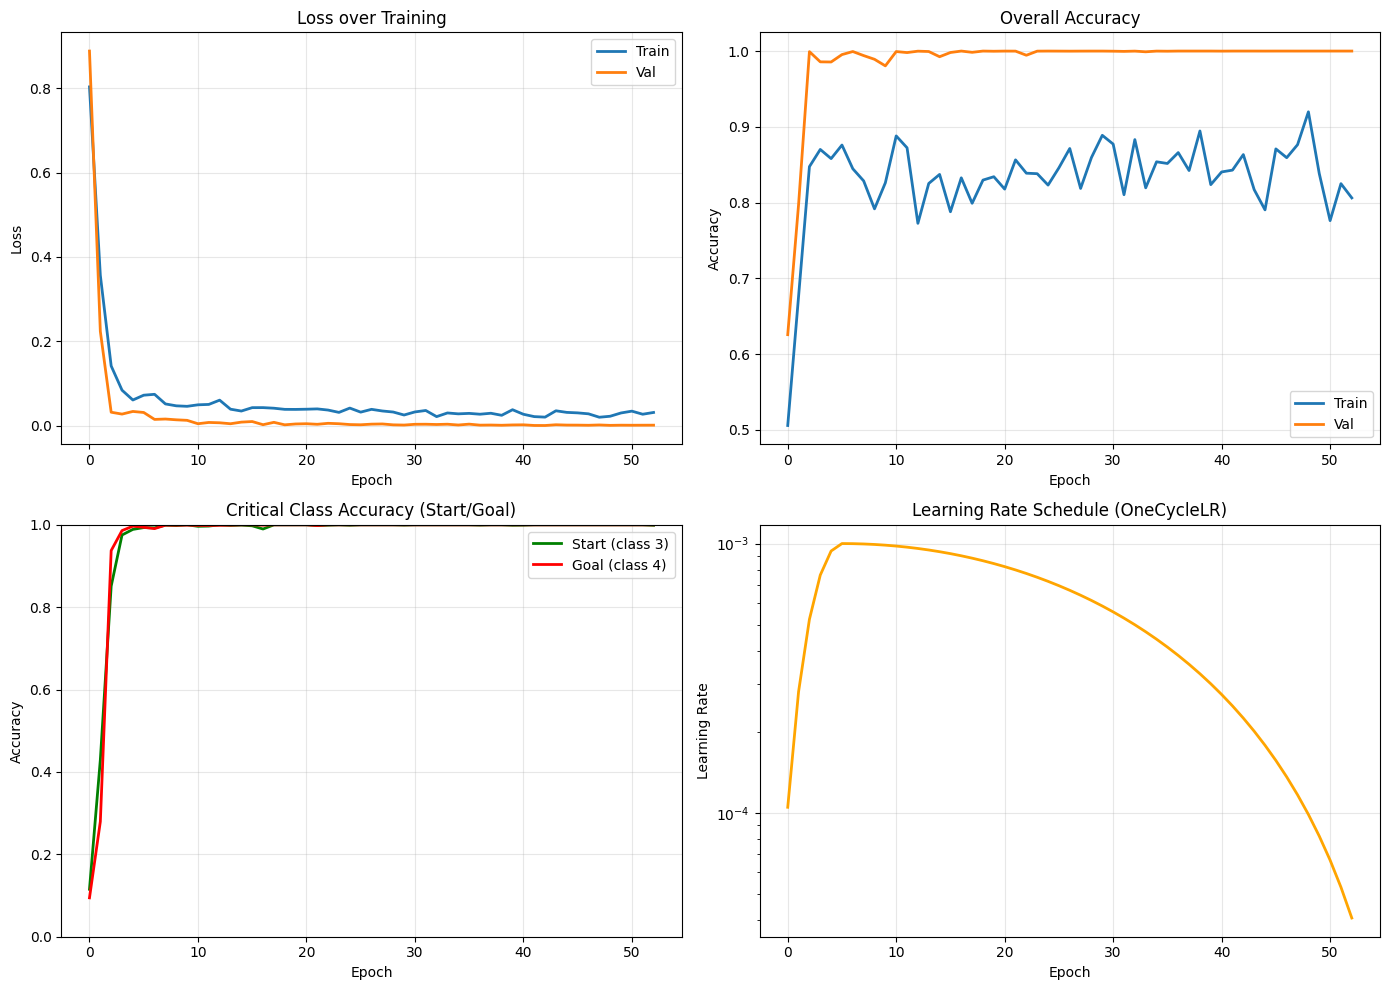


TRAINING SUMMARY
Final Train Accuracy: 0.8061
Final Val Accuracy: 1.0000
Best Start Accuracy: 1.0000
Best Goal Accuracy: 1.0000


In [28]:
# ==================== VISUALIZE TRAINING ====================
# Plot training history including rare class accuracy

try:
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2)
    if any(history['val_loss']):
        axes[0, 0].plot(history['val_loss'], label='Val', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Loss over Training')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[0, 1].plot(history['train_acc'], label='Train', linewidth=2)
    if any(history['val_acc']):
        axes[0, 1].plot(history['val_acc'], label='Val', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Overall Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Rare class accuracy (Start and Goal)
    axes[1, 0].plot(history['start_acc'], label='Start (class 3)', linewidth=2, color='green')
    axes[1, 0].plot(history['goal_acc'], label='Goal (class 4)', linewidth=2, color='red')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].set_title('Critical Class Accuracy (Start/Goal)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim(0, 1)
    
    # Learning rate
    axes[1, 1].plot(history['lr'], linewidth=2, color='orange')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_title('Learning Rate Schedule (OneCycleLR)')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "=" * 40)
    print("TRAINING SUMMARY")
    print("=" * 40)
    print(f"Final Train Accuracy: {history['train_acc'][-1]:.4f}")
    if any(history['val_acc']):
        print(f"Final Val Accuracy: {history['val_acc'][-1]:.4f}")
    print(f"Best Start Accuracy: {max(history['start_acc']):.4f}")
    print(f"Best Goal Accuracy: {max(history['goal_acc']):.4f}")
    
except ImportError:
    print("Install matplotlib for training visualization: pip install matplotlib")